## Module import

In [75]:
import os
import pathlib
import pickle
import string

import numpy as np
import pandas as pd
import torch

import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('wordnet')
dler = nltk.downloader.Downloader()
dler._update_index()
dler.download('omw-1.4')
# dler.download('all')

[nltk_data] Downloading package punkt to /home/ira/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ira/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/ira/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [2]:
# wmt_data_folder = os.path.join(os.pardir, 'data', 'wmt2016-seg-metric-dev-5lps/de-en')

---
## Data import

In [76]:
def get_data_paths(preproc_level):
    if preproc_level == 'raw':
        preproc_folder = 'raw_data'
    elif preproc_level == 'custom': # to lowercase + separate punctuation and special symbols
        preproc_folder = 'custom_preproc_data'
    elif preproc_level == 'custom_lowercase': # to lowercase + separate punctuation and special symbols
        preproc_folder = 'custom_lowercase_data'
    elif preproc_level == 'no_punct': # custom + no_punct
        preproc_folder = 'no_punct_data'    
    elif preproc_level == 'to_long_form': # custom + no_punct
        preproc_folder = 'long_form_data'    
    elif preproc_level == 'total': # custom + no_punct
        preproc_folder = 'total_preproc_data'        

    wmt_data_folder = os.path.join(os.pardir, 'data', 'wmt15', preproc_folder)
    
    mt_txt_path = os.path.join(wmt_data_folder, 'mt.txt')
    ref_txt_path = os.path.join(wmt_data_folder, 'reference.txt')
    srs_txt_path = os.path.join(wmt_data_folder, 'source.txt')
    
    return preproc_folder, mt_txt_path, ref_txt_path, srs_txt_path

In [77]:
preproc_level = 'raw'
preproc_folder, mt_txt_path, ref_txt_path, srs_txt_path = get_data_paths(preproc_level)

original_wmt_folder = os.path.join(os.pardir, 'data', 'wmt15', 'de-en')

human_score_path = os.path.join(original_wmt_folder, 'newstest2015.human.de-en')
bleu_score_path = os.path.join(original_wmt_folder, 'newstest2015.sbleumoses.de-en')

In [78]:
# Read text data: reference translation, source sentence, MT-output
with open(ref_txt_path) as f:
    ref_snts = f.readlines()
    ref_snts = [s[:-1] for s in ref_snts]

with open(srs_txt_path) as f:
    src_snts = f.readlines()
    src_snts = [s[:-1] for s in src_snts]

with open(mt_txt_path) as f:
    mt_snts = f.readlines()
    mt_snts = [s[:-1] for s in mt_snts]

len(ref_snts), len(src_snts), len(mt_snts)

(500, 500, 500)

In [79]:
human_score = pd.read_csv(human_score_path, names=['wmt_human_score'])

In [80]:
# Currently, metrics scores are precomputed only for raw data. 
# Check the `data` folder for updates.
metric_scores_folder = os.path.join(os.pardir, 'data', 
                                    f'precomputed_metric_scores_for_newstest15_{preproc_folder}')

### Tokenize text as input has to be provided in tokens for some packages, e.g. NLTK

In [81]:
src_tokens = [s.split() for s in src_snts]
ref_tokens = [s.split() for s in ref_snts]
mt_tokens = [s.split() for s in mt_snts]

---
## Collect metric scores

In [82]:
metric_scores = pd.DataFrame(data={'da_score': human_score['wmt_human_score']})

### BLEU, ChrF, TER from SacreBLEU framework


In [83]:
import sacrebleu as sb

sb_chrf = sb.CHRF()
sb_ter = sb.TER()
sb_bleu = sb.BLEU()

sb_bleu.effective_order = True
metric_scores['sacre_bleu'] = [sb_bleu.sentence_score(mt_snts[i], [ref_snts[i]]).score / 100 for i in range(len(mt_snts))]
metric_scores['sacre_chrf'] = [sb_chrf.sentence_score(mt_snts[i], [ref_snts[i]]).score / 100 for i in range(len(mt_snts))]
metric_scores['sacre_ter'] = [(100 - sb_ter.sentence_score(mt_snts[i], [ref_snts[i]]).score) / 100 for i in range(len(mt_snts))]

In [84]:
metric_scores['human_score'] = metric_scores['da_score'] 

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='human_score', ylabel='sacre_bleu'>

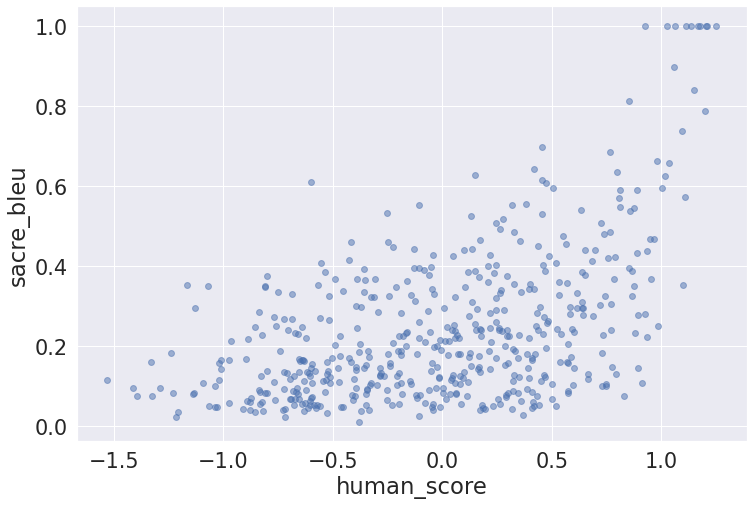

In [59]:
metric_scores.plot.scatter(x='human_score', y='sacre_bleu', alpha=0.5, figsize=(12,8), s=35, )

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='human_score', ylabel='sacre_chrf'>

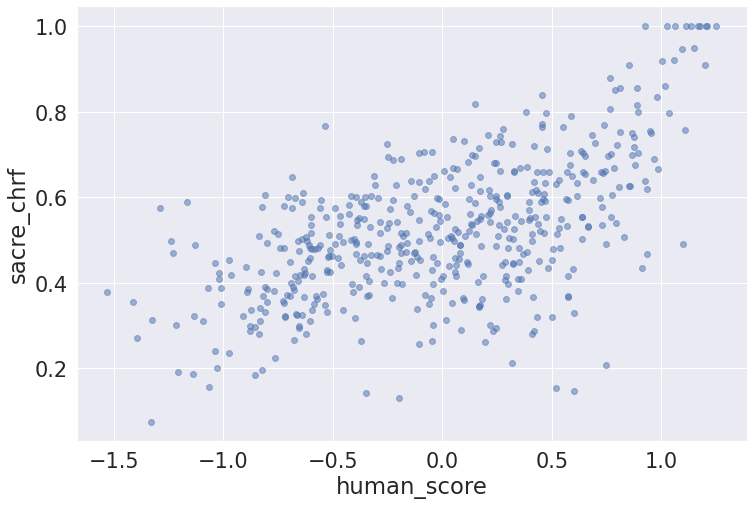

In [60]:
metric_scores.plot.scatter(x='human_score', y='sacre_chrf', alpha=0.5, figsize=(12,8), s=35, )

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='human_score', ylabel='sacre_ter'>

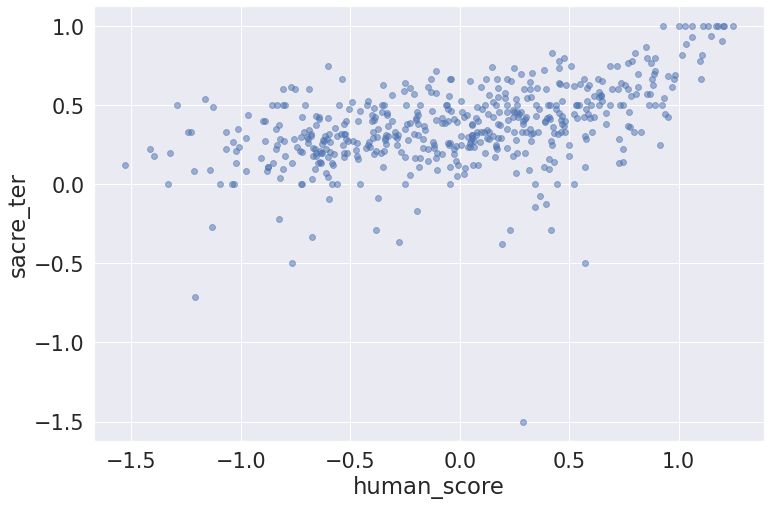

In [61]:
metric_scores.plot.scatter(x='human_score', y='sacre_ter', alpha=0.5, figsize=(12,8), s=35, )

### NIST, METEOR, RIBES from NLTK

In [85]:
from nltk.translate import meteor_score, nist_score, ribes_score

In [86]:
metric_scores['nltk_meteor'] = [meteor_score.meteor_score(
    [ref_tokens[i]], mt_tokens[i]) for i in range(len(ref_tokens))]

metric_scores['nltk_nist'] = [nist_score.sentence_nist(
    [ref_tokens[i]], mt_tokens[i], n=2) for i in range(len(ref_tokens))]

metric_scores['nltk_ribes'] = [ribes_score.sentence_ribes(
    [ref_tokens[i]], mt_tokens[i]) for i in range(len(ref_tokens))]

### HLEPOR

In [87]:
from hlepor import single_hlepor_score, hlepor_score
metric_scores['hlepor'] = [single_hlepor_score(ref_snts[i], mt_snts[i]) for i in range(len(ref_snts))]

In [88]:
metric_scores.corr() # raw

,da_score,sacre_bleu,sacre_chrf,sacre_ter,human_score,nltk_meteor,nltk_nist,nltk_ribes,hlepor
da_score,1.000000,0.529450,0.603899,0.483918,1.000000,0.553237,0.322578,0.375626,0.541315
sacre_bleu,0.529450,1.000000,0.811077,0.763829,0.529450,0.788350,0.567491,0.696679,0.754973
sacre_chrf,0.603899,0.811077,1.000000,0.703930,0.603899,0.843940,0.665818,0.538601,0.824923
sacre_ter,0.483918,0.763829,0.703930,1.000000,0.483918,0.807853,0.645692,0.527145,0.705068
human_score,1.000000,0.529450,0.603899,0.483918,1.000000,0.553237,0.322578,0.375626,0.541315
nltk_meteor,0.553237,0.788350,0.843940,0.807853,0.553237,1.000000,0.699609,0.555938,0.832870
nltk_nist,0.322578,0.567491,0.665818,0.645692,0.322578,0.699609,1.000000,0.175935,0.642544
nltk_ribes,0.375626,0.696679,0.538601,0.527145,0.375626,0.555938,0.175935,1.000000,0.428976
hlepor,0.541315,0.754973,0.824923,0.705068,0.541315,0.832870,0.642544,0.428976,1.000000


### GTM

In [89]:
gtm_path = os.path.join(metric_scores_folder, 'gtm_report.txt')
with open(gtm_path, 'r') as f:
    gtm_report = f.readlines()

gtm_scores = []
for l in gtm_report:
    if 'sampledoc' in l:
        scores = l[:-1].split(' ')
        if len(scores) == 3:
            score = float(scores[2])
            gtm_scores.append(score)

metric_scores['gtm'] = gtm_scores

### ROUGE

In [90]:
rouge_scores_path = os.path.join(metric_scores_folder, 'all_rouge_scores.csv')
rouge_df = pd.read_csv(rouge_scores_path)
metric_scores = pd.concat([metric_scores, 
                           rouge_df[['rouge_l_f1', 'rouge_1_f1', 'rouge_1_p', 'rouge_1_r']]], axis=1)

### TERp

In [91]:
terp_scores_path = os.path.join(metric_scores_folder, "terpa.simple.seg.scr")
terp_scores = pd.read_csv(terp_scores_path, sep='\t', 
                          header=None, names=['sys_id', 'col', 'doc_id', 'seg_id', 'terp','words_count'])
metric_scores['terp'] = 1 - terp_scores['terp'].values

### BEER

In [92]:
beer_score_path = os.path.join(metric_scores_folder, 'beer_scores.txt')
beer = pd.read_csv(beer_score_path, names=['c1', 'c2', 'beer'], delimiter=' ')
beer_total = beer.loc['total']
beer_score = beer.loc['sent'][['beer']]
metric_scores['beer'] = beer_score.values

### WMD

In [93]:
wmd_score_path = os.path.join(metric_scores_folder, 'wmd_scores_15.pickle')
with open(wmd_score_path, 'rb') as f:
    wmd_scores = pickle.load(f)
metric_scores['wmd_score'] = wmd_scores

In [20]:
# metric_scores[metric_scores.wmd_score == np.inf]

In [21]:
# Invert wmd score to measure similarity rather dissimilarity
# I couldn't find why wmd_scores contain inf value since they assign it both to good and to bad translation.
# However, all sentences with `inf` score are quite short. Maybe that's the reason.

# print(mt_snts[435], ref_snts[435])

# wmd_avg_value = metric_scores[metric_scores.wmd_score != np.inf].wmd_score.mean()
# updated_wmd_scores = [s if s != np.inf else wmd_avg_value for s in wmd_scores]
# updated_wmd_scores = [(max(updated_wmd_scores) - s) / (max(updated_wmd_scores) - min(updated_wmd_scores)) 
#                       for s in updated_wmd_scores]
# metric_scores['wmd_score_inv'] = updated_wmd_scores

### MoverScore

In [94]:
# model = bert-base-multilingual-uncased
mover_score_path = os.path.join(metric_scores_folder, 'mover_scores.pickle')
with open(mover_score_path, 'rb') as f:
    mover_scores = pickle.load(f)
metric_scores['mover_score'] = mover_scores

### PRISM

In [95]:
prism_score_path = os.path.join(metric_scores_folder, 'prism_scores.pickle')
with open(prism_score_path, 'rb') as f:
    prism_scores = pickle.load(f)
prism_scores

,prism_ref,prism_src
0,-1.206791,-1.241422
1,-1.368211,-0.445980
2,-2.688500,-2.712787
3,-1.954940,-1.596547
4,-3.027613,-1.633816
...,...,...
495,-2.286199,-0.930361
496,-1.833128,-1.517493
497,-2.908791,-2.524722
498,-1.697418,-1.521556


In [96]:
metric_scores['prism_ref'] = prism_scores['prism_ref'].values
metric_scores['prism_src'] = prism_scores['prism_src'].values

### YISI

In [97]:
yisi_score_path = os.path.join(metric_scores_folder, 'yisi_no_srl_wmt15.sntyisi1')
with open(yisi_score_path, 'r') as f:
     yisi_scores = f.readlines()
yisi_scores = [float(score[:-1]) for score in yisi_scores]
metric_scores['yisi1_no_srl'] = yisi_scores

In [98]:
yisi1_score_path = os.path.join(metric_scores_folder, 'yisi_with_srl_wmt15.sntyisi1')
with open(yisi1_score_path, 'r') as f:
     yisi1_srl_scores = f.readlines()
yisi1_srl_scores = [float(score[:-1]) for score in yisi1_srl_scores]
metric_scores['yisi1_with_srl'] = yisi1_srl_scores

### BERTScore

In [99]:
import os
import pandas as pd

bert_scores_path = os.path.join(metric_scores_folder, 
                                'bert_scores_rescaled_with_baseline_deberta_roberta_bart.csv')
bert_df = pd.read_csv(bert_scores_path)

bert_df = bert_df[['bert_f1_deberta_xlarge_mnli', 'bert_f1_roberta_large_mnli', 'bert_f1_bart_mnli']]
metric_scores['bert_f1_deberta'] = bert_df['bert_f1_deberta_xlarge_mnli'].values
metric_scores['bert_f1_roberta'] = bert_df['bert_f1_roberta_large_mnli'].values
metric_scores['bert_f1_bart'] = bert_df['bert_f1_bart_mnli'].values

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='human_score', ylabel='bert_f1_deberta'>

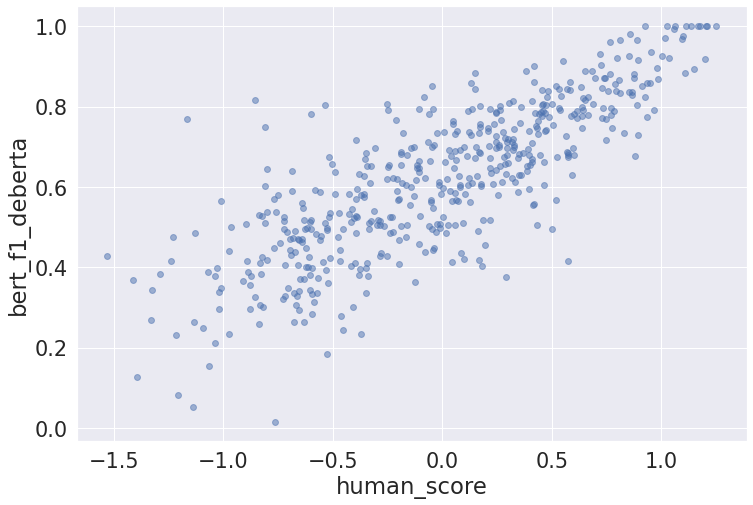

In [63]:
metric_scores.plot.scatter(x='human_score', y='bert_f1_deberta', alpha=0.5, figsize=(12,8), s=35, )

### BLEURT

In [100]:
# model = 'BLEURT-20'
bleurt_scores_path = os.path.join(metric_scores_folder, "bleurt_scores.pickle")
with open(bleurt_scores_path, 'rb') as f:
    bleurt_scores = pickle.load(f)
metric_scores['bleurt'] = bleurt_scores

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='human_score', ylabel='bleurt'>

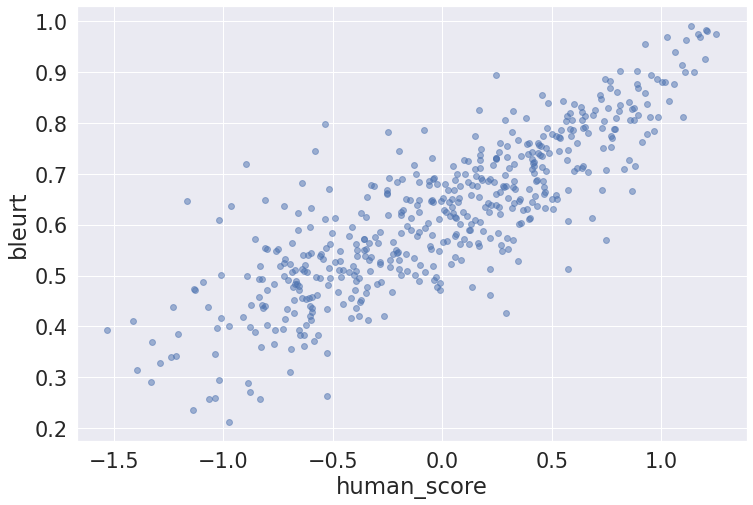

In [65]:
metric_scores.plot.scatter(x='human_score', y='bleurt', alpha=0.5, figsize=(12,8), s=35, )

### COMET

In [101]:
comet_score_path = os.path.join(metric_scores_folder, 'comet_scores.txt')
with open(comet_score_path, 'r') as f:
     comet_scores = f.readlines()
comet_scores = [float(s.replace('\n', '').split('score: ')[1]) for s in comet_scores]

comet_reference_less_score_path = os.path.join(metric_scores_folder, 'comet_reference_less.txt')
with open(comet_reference_less_score_path, 'r') as f:
     comet_reference_less_scores = f.readlines()
comet_reference_less_scores = [float(s.replace('\n', '').split('score: ')[1]) for s in comet_reference_less_scores]
comet_reference_less_scores = comet_reference_less_scores[:-1] # last score is avg score

comet_rank_score_path = os.path.join(metric_scores_folder, 'comet_rank.txt')
with open(comet_rank_score_path, 'r') as f:
     comet_rank_scores = f.readlines()
comet_rank_scores = [float(s.replace('\n', '').split('score: ')[1]) for s in comet_rank_scores]
comet_rank_scores = comet_rank_scores[:-1] # last score is avg score

In [102]:
metric_scores['comet_reg_da_20'] = comet_scores
metric_scores['comet_qe_da_20'] = comet_reference_less_scores
metric_scores['comet_rank_20'] = comet_rank_scores

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='human_score', ylabel='comet_reg_da_20'>

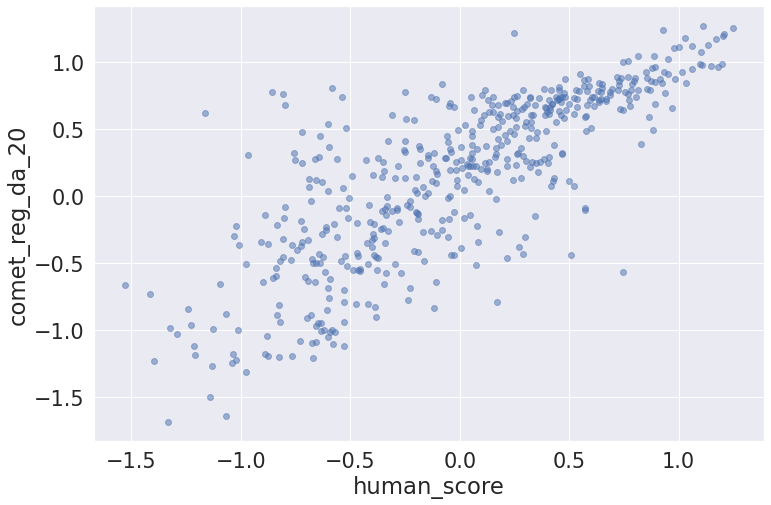

In [69]:
metric_scores.plot.scatter(x='human_score', y='comet_reg_da_20', alpha=0.5, figsize=(12,8), s=35, )

### MTEQA

In [103]:
mteqa_score_path = os.path.join(metric_scores_folder, 'mteqa_score_seg.tsv')
with open(mteqa_score_path, 'r') as f:
     mteqa_scores_orign = f.readlines()

mteqa_scores = [score[:-1].split('\t')[-4:] for score in mteqa_scores_orign]
mteqa_f1 = [float(scores[0]) for scores in mteqa_scores[1:]]
mteqa_em = [float(scores[1]) for scores in mteqa_scores[1:]]
mteqa_chrf = [float(scores[2]) for scores in mteqa_scores[1:]]
mteqa_bleu = [float(scores[3]) for scores in mteqa_scores[1:]]

metric_scores['mteqa_bleu'] = mteqa_bleu # bleu performs better than other metrics on the set of answers

## Correlation analysis

In [32]:
metric_scores

,da_score,sacre_bleu,sacre_chrf,sacre_ter,nltk_meteor,nltk_nist,nltk_ribes,hlepor,gtm,rouge_l_f1,...,yisi1_no_srl,yisi1_with_srl,bert_f1_deberta,bert_f1_roberta,bert_f1_bart,bleurt,comet_reg_da_20,comet_qe_da_20,comet_rank_20,mteqa_bleu
0,0.452788,0.530590,0.839434,0.642857,0.829421,2.855516,0.437102,0.884856,0.800000,81.250,...,0.682957,0.751654,0.777521,0.680547,0.876413,0.713813,0.6379,0.2694,0.1971,33.333333
1,0.485537,0.425011,0.658356,0.625000,0.665875,2.999399,0.204971,0.803472,0.680000,66.667,...,0.639036,0.607110,0.773811,0.715623,0.872672,0.741200,0.6417,0.7362,0.2177,16.567654
2,-0.888026,0.216791,0.385414,0.400000,0.452792,1.997620,0.290629,0.602932,0.486486,54.167,...,0.368075,0.588276,0.387459,0.146559,0.653076,0.288954,-1.1767,0.0000,0.1066,18.678794
3,0.407911,0.166379,0.497700,0.423077,0.485577,2.132511,0.117309,0.619509,0.461538,65.385,...,0.500965,0.575557,0.710076,0.607765,0.832859,0.644631,0.2910,0.0000,0.1300,35.913602
4,-0.640085,0.054314,0.324499,0.210526,0.186170,1.328737,0.072781,0.562964,0.388889,32.432,...,0.342996,0.474236,0.463830,0.430533,0.690301,0.456232,-0.4938,0.0000,0.1240,20.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.935312,0.221720,0.468053,0.444444,0.426136,1.387916,0.422476,0.486037,0.500000,58.824,...,0.359375,0.438519,0.774911,0.584986,0.836364,0.778087,0.7709,0.6977,0.1884,42.505353
496,0.407466,0.084976,0.515146,0.160000,0.523453,1.879326,0.326240,0.704530,0.500000,50.000,...,0.412930,0.568123,0.668322,0.609615,0.771410,0.709583,0.6162,0.2920,0.1082,31.841598
497,-1.037319,0.100462,0.446813,0.266667,0.298131,1.889405,0.083067,0.564657,0.379310,36.066,...,0.373938,0.564661,0.377834,0.225677,0.616356,0.259362,-1.1777,0.0000,0.0913,26.783288
498,0.216968,0.246500,0.563470,0.454545,0.495821,2.288870,0.172464,0.665912,0.491803,60.317,...,0.483425,0.651914,0.672642,0.594453,0.803527,0.512421,0.2269,0.0000,0.1308,50.718874


In [33]:
metric_scores.corr()

,da_score,sacre_bleu,sacre_chrf,sacre_ter,nltk_meteor,nltk_nist,nltk_ribes,hlepor,gtm,rouge_l_f1,...,yisi1_no_srl,yisi1_with_srl,bert_f1_deberta,bert_f1_roberta,bert_f1_bart,bleurt,comet_reg_da_20,comet_qe_da_20,comet_rank_20,mteqa_bleu
da_score,1.000000,0.529450,0.603899,0.483918,0.553237,0.322578,0.375626,0.541315,0.525959,0.606581,...,0.552485,0.569473,0.812576,0.771860,0.778379,0.841866,0.796684,0.624355,0.526237,0.369534
sacre_bleu,0.529450,1.000000,0.811077,0.763829,0.788350,0.567491,0.696679,0.754973,0.824587,0.795255,...,0.815998,0.657908,0.683808,0.671397,0.737592,0.621190,0.544808,0.458607,0.654556,0.323070
sacre_chrf,0.603899,0.811077,1.000000,0.703930,0.843940,0.665818,0.538601,0.824923,0.827332,0.830975,...,0.818010,0.734089,0.739202,0.705158,0.796394,0.658257,0.631947,0.422015,0.567253,0.404003
sacre_ter,0.483918,0.763829,0.703930,1.000000,0.807853,0.645692,0.527145,0.705068,0.842315,0.809582,...,0.793370,0.638675,0.669357,0.627394,0.716576,0.557667,0.537201,0.379254,0.486104,0.348590
nltk_meteor,0.553237,0.788350,0.843940,0.807853,1.000000,0.699609,0.555938,0.832870,0.897579,0.867273,...,0.879096,0.732437,0.707902,0.686144,0.772893,0.625195,0.595132,0.402156,0.497971,0.340534
nltk_nist,0.322578,0.567491,0.665818,0.645692,0.699609,1.000000,0.175935,0.642544,0.787039,0.603924,...,0.643816,0.558217,0.455865,0.381440,0.506671,0.328469,0.350696,0.128475,0.152900,0.176092
nltk_ribes,0.375626,0.696679,0.538601,0.527145,0.555938,0.175935,1.000000,0.428976,0.528777,0.529224,...,0.596714,0.444020,0.468874,0.493463,0.506526,0.442897,0.329402,0.331412,0.500142,0.191455
hlepor,0.541315,0.754973,0.824923,0.705068,0.832870,0.642544,0.428976,1.000000,0.834235,0.837715,...,0.803642,0.728283,0.717717,0.707306,0.779567,0.626179,0.620734,0.387403,0.493469,0.451918
gtm,0.525959,0.824587,0.827332,0.842315,0.897579,0.787039,0.528777,0.834235,1.000000,0.836217,...,0.879788,0.733141,0.701055,0.673564,0.764314,0.601146,0.570159,0.384633,0.521579,0.352029
rouge_l_f1,0.606581,0.795255,0.830975,0.809582,0.867273,0.603924,0.529224,0.837715,0.836217,1.000000,...,0.804781,0.723925,0.760521,0.734999,0.822332,0.689800,0.667103,0.455595,0.545692,0.415989


#### Correlation heatmaps

In [104]:
import seaborn as sns
import matplotlib.pyplot as plt

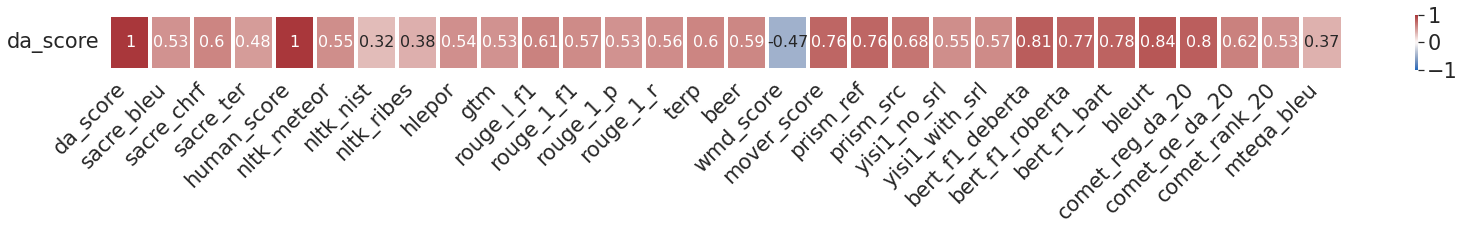

In [105]:
sns.set(rc={'figure.figsize':(26, 1)})
sns.set(font_scale=1.9)

m = metric_scores.corr().round(2)[:1]

fig = sns.heatmap(m, annot=True, vmax=1, vmin=-1, center=0, cmap='vlag', annot_kws={"size": 16},
                 cbar_kws={'fraction' : 0.1}, linewidth=4)

fig.set_xticklabels(fig.get_xticklabels(), rotation=45, horizontalalignment='right')
fig.set_yticklabels(fig.get_yticklabels(), rotation=0, horizontalalignment='right')
plt.show()

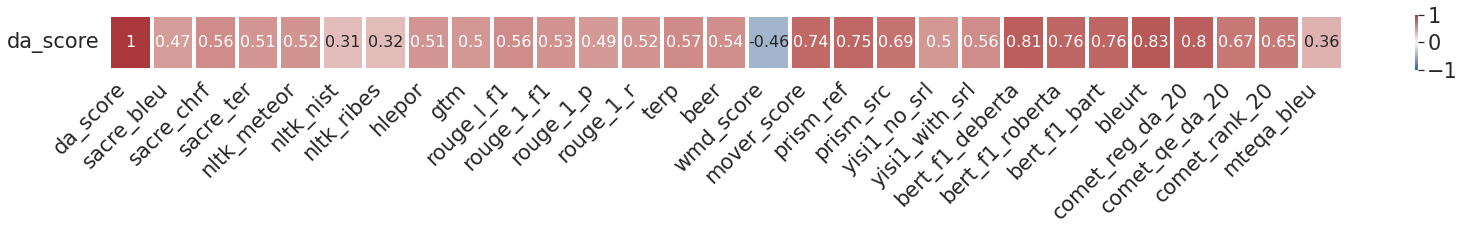

In [39]:
sns.set(rc={'figure.figsize':(26, 1)})
sns.set(font_scale=1.9)

m = metric_scores.corr(method='spearman').round(2)[:1]
# m = m[columns]

fig = sns.heatmap(m, annot=True, vmax=1, vmin=-1, center=0, cmap='vlag', annot_kws={"size": 16},
                 cbar_kws={'fraction' : 0.1}, linewidth=4)

fig.set_xticklabels(fig.get_xticklabels(), rotation=45, horizontalalignment='right')
fig.set_yticklabels(fig.get_yticklabels(), rotation=0, horizontalalignment='right')
plt.show()

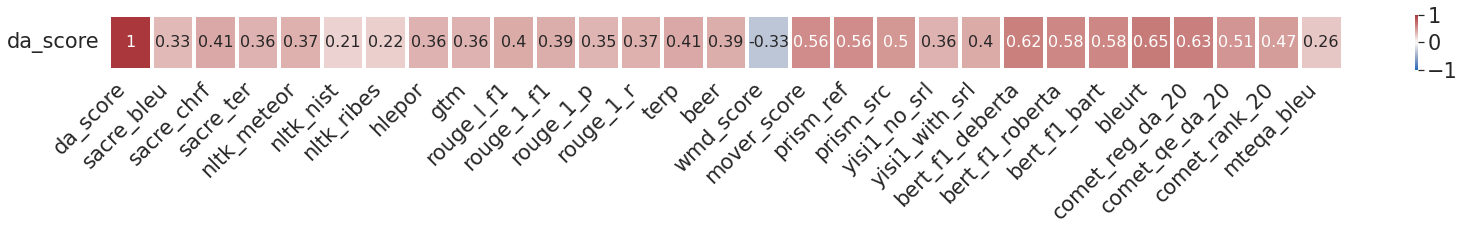

In [40]:
sns.set(rc={'figure.figsize':(26, 1)})
sns.set(font_scale=1.9)

m = metric_scores.corr(method='kendall').round(2)[:1]
# m = m[columns]

fig = sns.heatmap(m, annot=True, vmax=1, vmin=-1, center=0, cmap='vlag', annot_kws={"size": 16},
                 cbar_kws={'fraction' : 0.1}, linewidth=4)

fig.set_xticklabels(fig.get_xticklabels(), rotation=45, horizontalalignment='right')
fig.set_yticklabels(fig.get_yticklabels(), rotation=0, horizontalalignment='right')
plt.show()

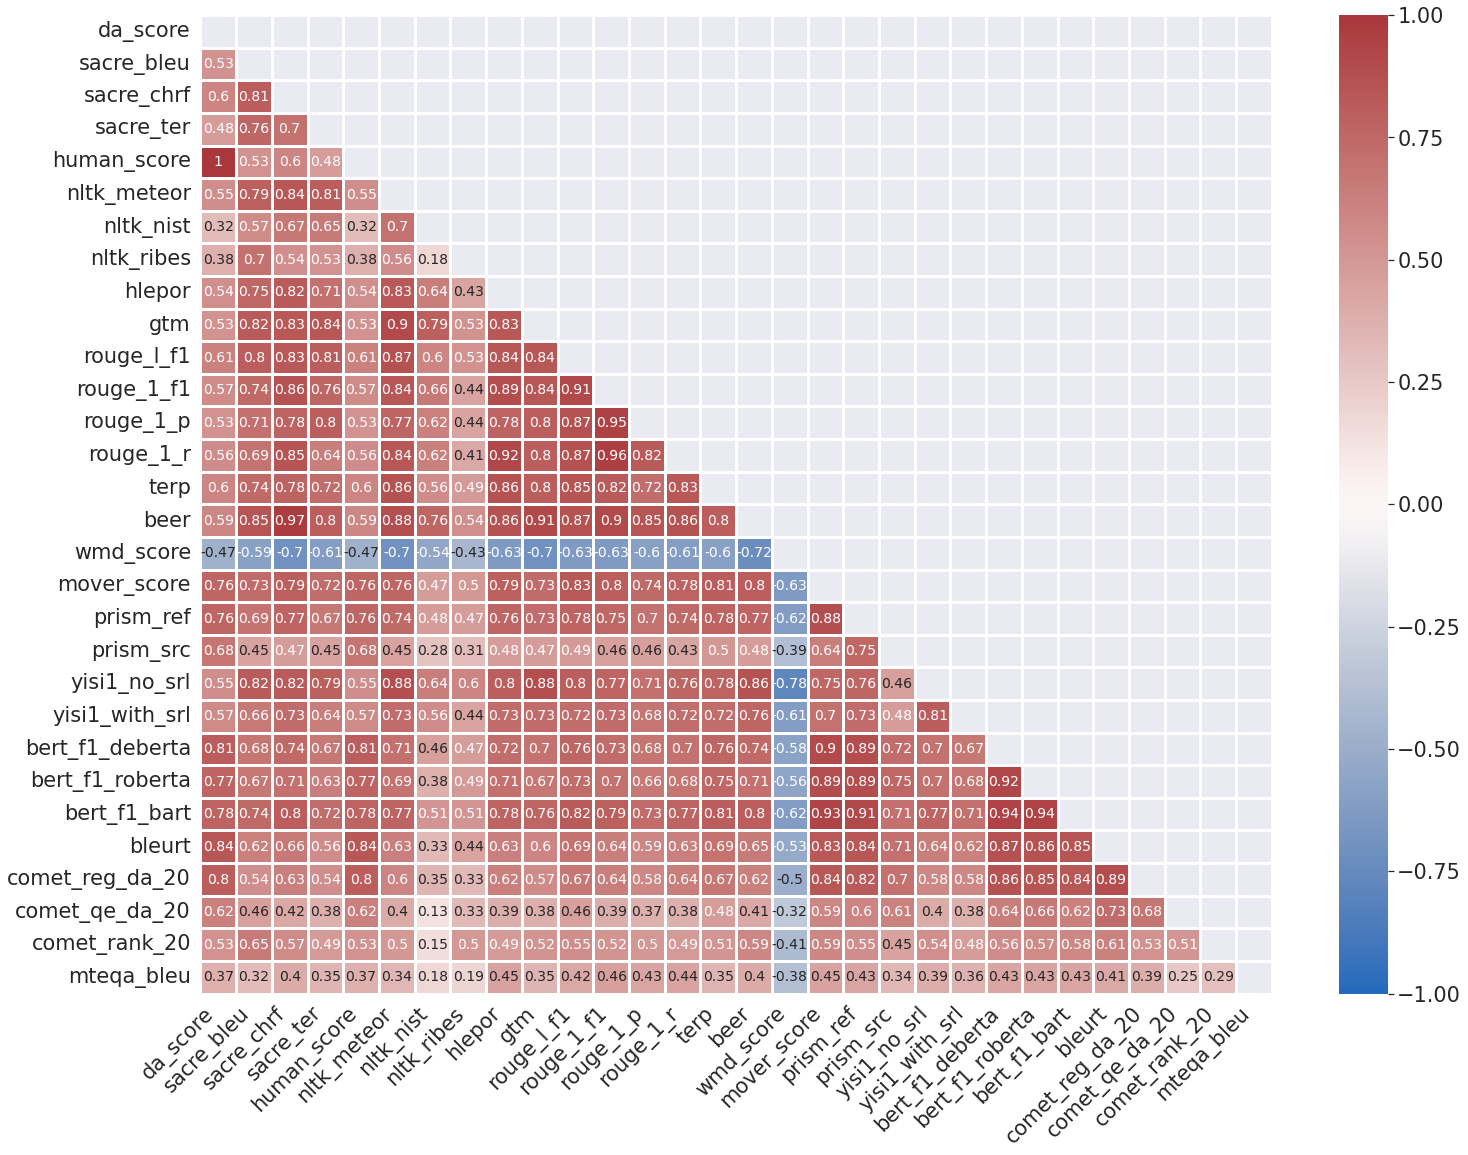

In [112]:
# Pearson

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(24, 18)})
sns.set(font_scale=1.9)

matrix = metric_scores.corr().round(2)
# matrix = matrix[columns]
mask = np.triu(np.ones_like(matrix, dtype=bool))
fig = sns.heatmap(matrix, annot=True, vmax=1, vmin=-1, center=0, cmap='vlag', mask=mask, 
                  annot_kws={"size": 14}, linewidth=3)

fig.set_xticklabels(fig.get_xticklabels(), rotation=45, horizontalalignment='right')

print()
plt.show()

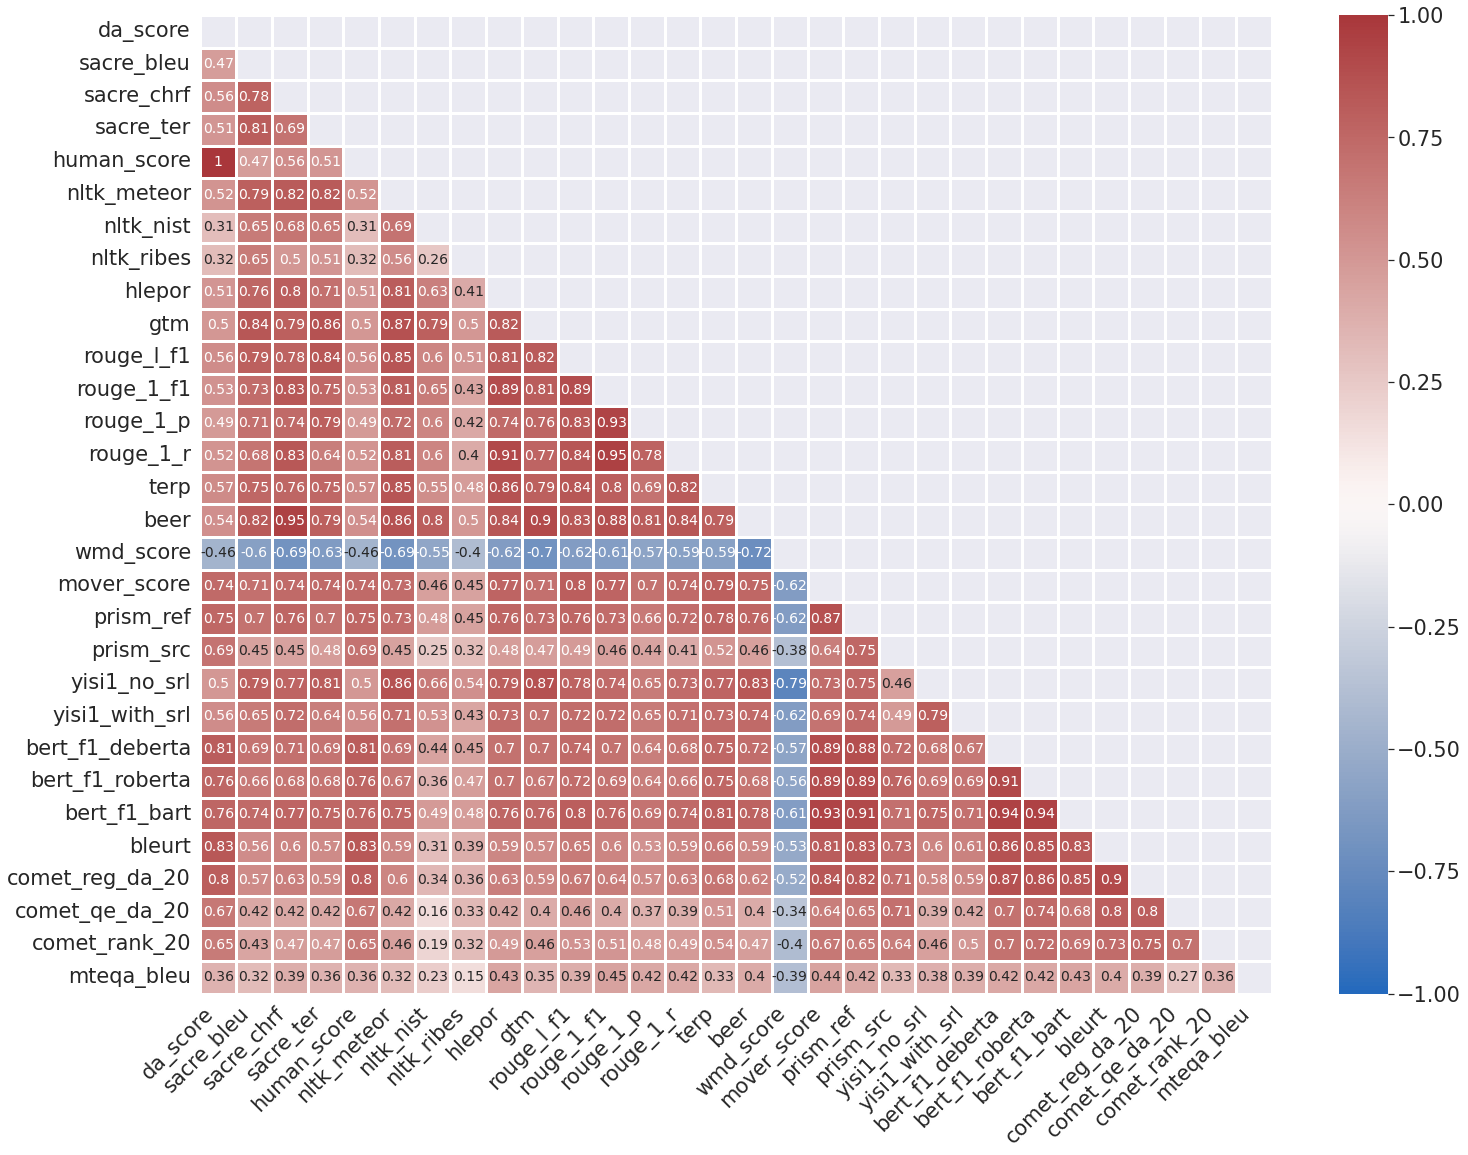

In [113]:
# Spearman

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(24, 18)})
sns.set(font_scale=1.9)

matrix = metric_scores.corr(method='spearman').round(2)
mask = np.triu(np.ones_like(matrix, dtype=bool))
# matrix = matrix[columns]
fig = sns.heatmap(matrix, annot=True, vmax=1, vmin=-1, center=0, cmap='vlag', mask=mask, 
                  annot_kws={"size": 14}, linewidth=3)

fig.set_xticklabels(fig.get_xticklabels(), rotation=45, horizontalalignment='right')

print()
plt.show()

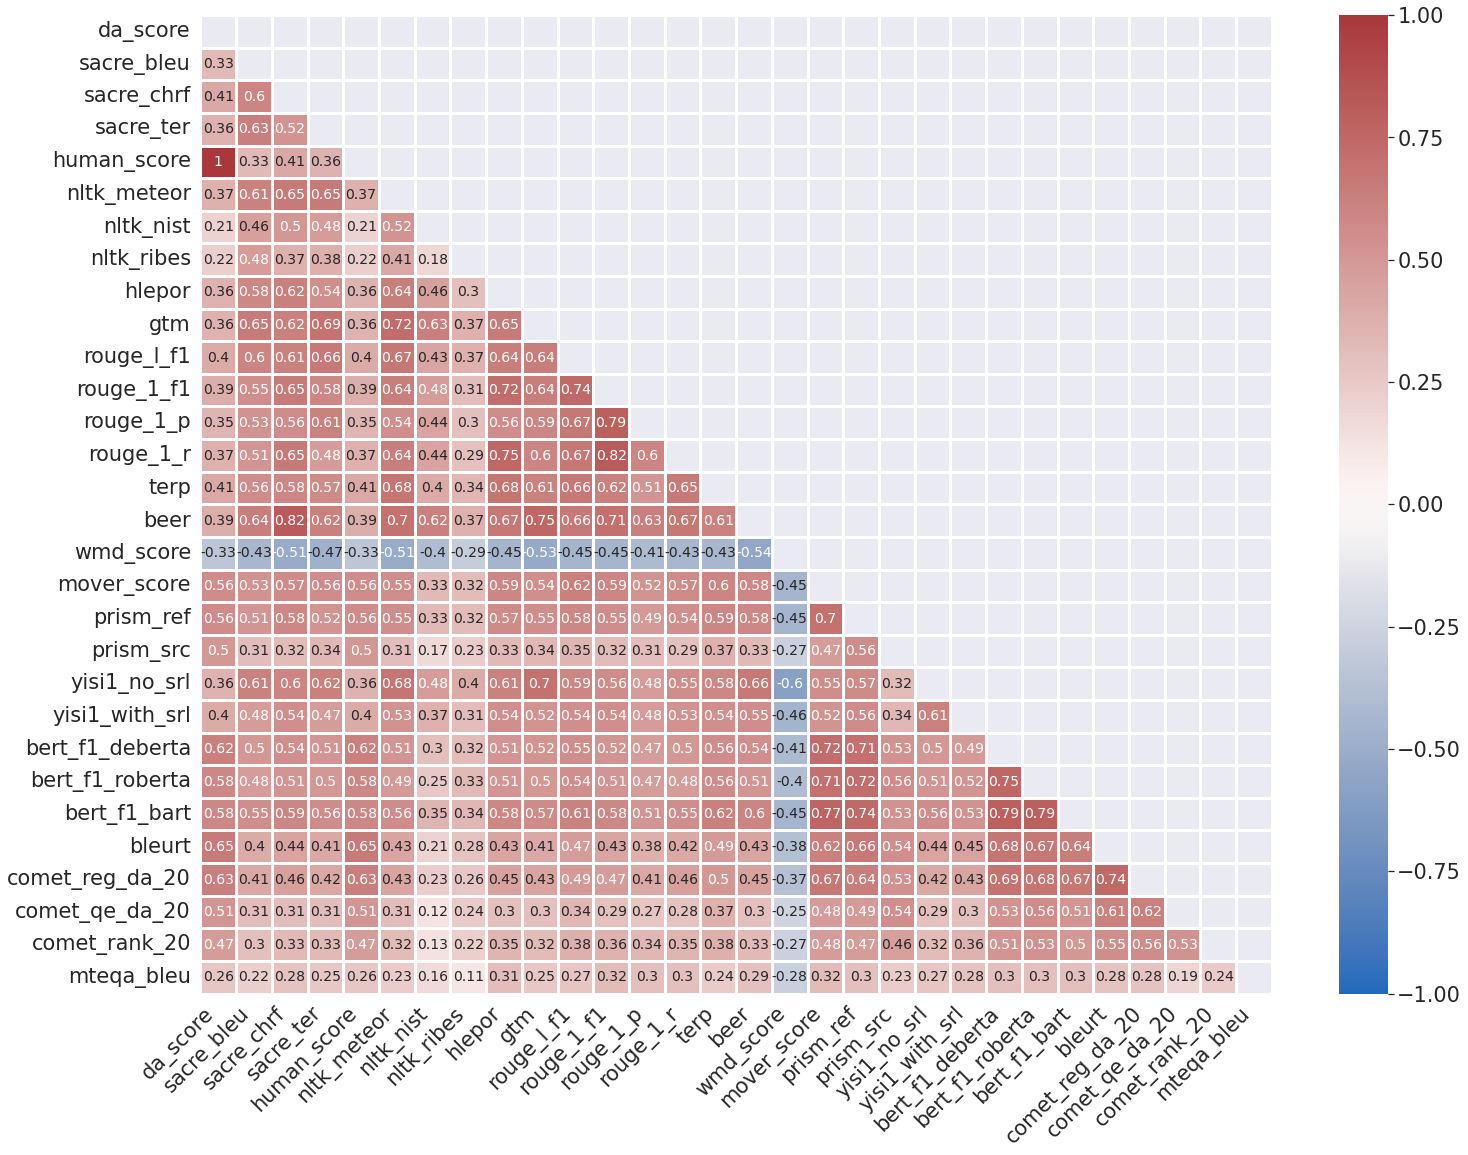

In [114]:
# Kendall

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(24, 18)})
sns.set(font_scale=1.9)

matrix = metric_scores.corr(method='kendall').round(2)
mask = np.triu(np.ones_like(matrix, dtype=bool))
# matrix = matrix[columns]
fig = sns.heatmap(matrix, annot=True, vmax=1, vmin=-1, center=0, cmap='vlag', mask=mask, 
                  annot_kws={"size": 14}, linewidth=3)

fig.set_xticklabels(fig.get_xticklabels(), rotation=45, horizontalalignment='right')

print()
plt.show()